# 1. Goal

The goals of this project are to (i) learn how to implement gradient descent function optimization and (ii) lock in the understanding of regularized linear models.

Gradient descent optimizers are critical to training many important models, such as neural networks where each neuron in the network is a linear regression model. I will implement ordinary least squares (OLS) regression,
L2 regularization for regression, and logistic regression.

I will construct drop-in replacements for the following scikit-learn’s models:
- LinearRegression
- Ridge (L2 regularized regression)
- LogisticRegression (nonregularized only)

# 2. Loss Function Brief Overview

Training linear models involves optimizing a function, called a loss function, that describes how well the model’s predictions match the known target values; i.e., how well the $\hat{y}$ values match y for all $y^{i}$ in the (__X__, __y__) training set. Given the model parameters (β coefficients), the loss function gives a scalar value indicating a “goodness of fit” for the training data. The smaller the loss, the better the fit to the training data. Optimizing the loss function means finding the model parameters that give the minimum loss function scalar value. 

For the vanilla linear regression model, the loss function is just the mean squared error (MSE):

The linear regression model can be represented as:

$$
\hat{y}_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip}
$$

The Mean Squared Error (MSE) loss function is defined as:

$$
MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

Substituting the linear regression model into the MSE equation, we get:

$$
MSE = \frac{1}{n} \sum_{i=1}^n \left(y_i - (\beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip})\right)^2
$$


# 3. Gradient Descent Brief Overview

Without regularization, the loss function is a quadratic (by construction), which is convex and has an exact solution. However, we often solve problems iteratively rather than symbolically, as it's necessary for logistic regression and sometimes for regularized linear regression. We will drop the vector notation from β now for convenience and assume it includes β₀.

So, how do we know where the optimal coefficients are in p + 1 space? We pick an initial approximation to β and then use information about the loss function in the neighborhood of that β to decide which direction shifts it towards a better loss function:

$$
\beta^{(t+1)} = \beta^{(t)} + \Delta\beta^{(t)}
$$

where $\Delta\beta^{(t)}$ is a shift in the direction of lower loss function value. That $\Delta\beta^{(t)}$ turns out to be the opposite of the gradient vector, as shown in this 1D case:

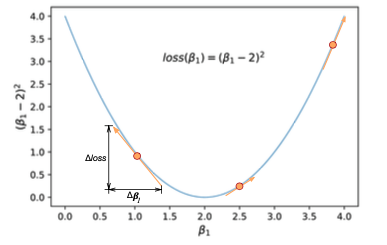

Here's what a regression model loss function looks like for $(\beta_0, \beta_1)$:

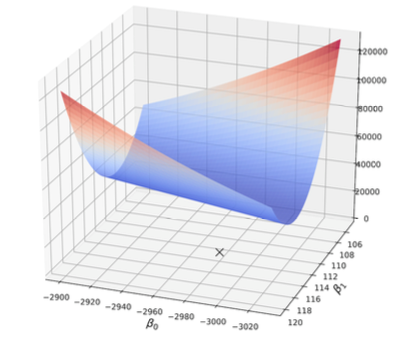

The gradient vector is the vector of slopes in each of p + 1 directions, and the slope always points in the up direction, so we want to go in the negative of the gradient to go downhill. Our movement is governed by the following recurrence relation:

$$
\beta^{(t+1)} = \beta^{(t)} - \eta \nabla_\beta L(\beta^{(t)})
$$

where $\eta$ is a scalar "learning rate" that controls the magnitude of the step we take at each step t. We're done optimizing when we find a β where all slopes are zero/flat (when the magnitude of the gradient vector is zero):

$$
\nabla_\beta L(\beta) = \vec{0}
$$

So, in a nutshell, to optimize a loss function, we need the loss function gradient. 

For example, here is a complete Python program for p = 1 that optimizes $y = (x - 2)^2$ using the derivative $dy = 2(x - 2)$:


In [8]:
import numpy as np

def f(b): # loss function
    return (b - 2) ** 2

def gradient(b): # loss function gradient w.r.t b
    return 2 * (b - 2)

b = np.random.random()  # initial guess at optimal b
niter = 10             # number of iterations
rate = 0.1              # learning rate

for i in range(niter):
    print(f"{i:02d}: beta_1={b:.2f}, f(beta_1)={f(b):.2f}, gradient {gradient(b):.2f}")
    b = b - rate * gradient(b)


00: beta_1=0.45, f(beta_1)=2.42, gradient -3.11
01: beta_1=0.76, f(beta_1)=1.55, gradient -2.49
02: beta_1=1.01, f(beta_1)=0.99, gradient -1.99
03: beta_1=1.20, f(beta_1)=0.63, gradient -1.59
04: beta_1=1.36, f(beta_1)=0.41, gradient -1.27
05: beta_1=1.49, f(beta_1)=0.26, gradient -1.02
06: beta_1=1.59, f(beta_1)=0.17, gradient -0.82
07: beta_1=1.67, f(beta_1)=0.11, gradient -0.65
08: beta_1=1.74, f(beta_1)=0.07, gradient -0.52
09: beta_1=1.79, f(beta_1)=0.04, gradient -0.42


*Note that this example is not a linear regression problem, but it illustrates the gradient descent optimization concept that can be applied to linear regression and other machine learning problems.*

This program simply terminates after a certain number of iterations, but in general we have to continue until the gradient is zero or the β’s or loss don’t move from one step to the next. An easy and efficient termination condition is to stop when the norm of the gradient vector is below some threshold.
Once we have suitable minimization functionality, we can use it to optimize linear and logistic regression equations, both normal and regularized.

In [19]:
def minimize(X, y, loss, loss_gradient,
              eta=0.00001, lmbda=0.0,
              max_iter=1000, addB0=True,
              precision=1e-9):
    "A minimize function to optimize the model using gradient descent. "
    if X.ndim != 2:
        raise ValueError("X must be n x p for p features")
    n, p = X.shape
    if y.shape != (n, 1):
        raise ValueError(f"y must be n={n} x 1 not {y.shape}")
    
    if addB0:  # add column of 1s to X, add B0 to B 
        B0 = np.ones(shape=(n, 1))
        X = np.hstack([B0, X])
        B = np.random.random_sample(size=(p+1, 1)) * 2 - 1  # make between [-1,1) 
        h = np.zeros(shape=(p+1, 1))   # p+1 sized sum of squared gradient history 
    else:     
        B = np.random.random_sample(size=(p, 1)) * 2 - 1  # make between [-1,1) 
        h = np.zeros(shape=(p, 1))     # p+1 sized sum of squared gradient history 

    step = 0
    eps = 1e-5 # prevent division by 0
    
    while step < max_iter:
        cur_loss_gradient = loss_gradient(X, y, B, lmbda)
        if np.linalg.norm(cur_loss_gradient) >= precision:
            step += 1
            h += np.square(cur_loss_gradient)  # track sum of squared partials, use element-wise product
            B = B - eta * cur_loss_gradient / (np.sqrt(h) + eps)
        else:
            break
            
    return B

In the following sections, I will construct drop-in replacements for the three scikit-learn’s models:
- LinearRegression
- Ridge (L2 regularized regression)
- LogisticRegression (nonregularized only)

# 4. Implementation - LinearRegression 

For a dataset with n observations and p features, the linear regression model can be represented as:

$$
\hat{y}_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip}
$$

where $\hat{y}_i$ is the predicted value for the i-th observation, $x_{ij}$ is the j-th feature value of the i-th observation, and $\beta_j$ are the coefficients of the linear model (including the intercept $\beta_0$).


### Loss Function (Mean Squared Error)

The Mean Squared Error (MSE) loss function for linear regression is defined as:

$$
MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

where $y_i$ is the actual value of the i-th observation and $\hat{y}_i$ is the predicted value for the i-th observation.

In [13]:
def MSE(X, y, B, lmbda):
    """
    The Mean Squared Error (MSE) loss function for linear regression.
    X.shape: (n, p+1)
    B.shape: (p+1, 1)
    y.shape: (n, 1)
    return a 1 by 1 scalar
    """
    return np.dot(np.transpose(y - np.dot(X, B)), y - np.dot(X, B))

### Gradient of the Loss Function

To compute the gradient of the MSE loss function with respect to the coefficients $\beta_j$, we differentiate the MSE with respect to each $\beta_j$:

$$
\frac{\partial MSE}{\partial \beta_j} = \frac{\partial}{\partial \beta_j} \frac{1}{n} \sum_{i=1}^n (y_i - (\beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip}))^2
$$

After differentiation, we obtain the gradient of the loss function:

$$
\frac{\partial MSE}{\partial \beta_0} = \frac{-2}{n} \sum_{i=1}^n (y_i - \hat{y}_i)
$$

$$
\frac{\partial MSE}{\partial \beta_j} = \frac{-2}{n} \sum_{i=1}^n x_{ij} (y_i - \hat{y}_i) \quad \text{for}\ j = 1, 2, ..., p
$$

The gradient vector of the loss function is:

$$
\nabla_\beta MSE = \begin{bmatrix} \frac{\partial MSE}{\partial \beta_0} \\ \frac{\partial MSE}{\partial \beta_1} \\ \vdots \\ \frac{\partial MSE}{\partial \beta_p} \end{bmatrix}
$$


In [14]:
def loss_gradient(X, y, B, lmbda):
    """
    The gradient vector  of the MSE loss function 
    X.shape: (n, p+1)   add the column of one's to X
    B.shape: (p+1, 1)   put beta_0 into beta
    y.shape: (n, 1)
    return a vector of shape (p+1, 1)
    """
    return - np.dot(np.transpose(X), y - np.dot(X, B))

### Class Implementation

Finally, I created a LinearRegression621 class that can be used to fit the model and make predictions:

In [22]:
class LinearRegression621: 
    def __init__(self,
                 eta=0.00001, lmbda=0.0,
                 max_iter=1000):
        self.eta = eta
        self.lmbda = lmbda
        self.max_iter = max_iter

    def predict(self, X):
        n = X.shape[0]
        B0 = np.ones(shape=(n, 1))
        X = np.hstack([B0, X])
        return np.dot(X, self.B)

    def fit(self, X, y):
        self.B = minimize(X, y,
                           MSE,
                           loss_gradient,
                           self.eta,
                           self.lmbda,
                           self.max_iter)

### Test

Now, let's generate some dataset to test our LinearRegression621.

In [27]:
import numpy as np
import pandas as pd
from scipy.special import lmbda

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

First, define a normalize function that is used to standardize the input features in a dataset. Standardization is a common preprocessing step in machine learning, which scales the features to have zero mean and unit variance. This helps to ensure that all features are on a similar scale and prevents any one feature from dominating the model due to its larger magnitude.

The normalization process can improve the performance of some machine learning algorithms, particularly those that are sensitive to the scale of input features, such as gradient descent-based optimization methods or distance-based algorithms (e.g., k-Nearest Neighbors).

In [37]:
def normalize(X):
    if isinstance(X, pd.DataFrame):
        for c in X.columns:
            if is_numeric_dtype(X[c]):
                u = np.mean(X[c])
                s = np.std(X[c])
                X[c] = (X[c] - u) / s
        return
    for j in range(X.shape[1]):
        u = np.mean(X[:,j])
        s = np.std(X[:,j])
        X[:,j] = (X[:,j] - u) / s

Then, let's design a check function to test the performance of the custom linear regression implementation (LinearRegression621) against a widely-used implementation from the scikit-learn library.

In [38]:
def MAE(a,b): return np.mean(np.abs(a.flatten()-b.flatten()))

def check(X, y, mae, model, skmodel, r2_diff):
    normalize(X)

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.10, shuffle=True)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    print("r^2", r2)

    estimated_B = model.B.reshape(-1)

    skmodel.fit(X_train, y_train.reshape(-1,1))
    y_pred = skmodel.predict(X_test)
    skr2 = r2_score(y_test.reshape(-1,1), y_pred)
    print("sklearn r^2", skr2)
    if skmodel.coef_.ndim==2:
        true_B = np.concatenate([skmodel.intercept_, skmodel.coef_[0]])
    else:
        true_B = np.concatenate([skmodel.intercept_, skmodel.coef_])

    estimated_B = estimated_B[0:13]
    true_B = true_B[0:13]

    r = pd.DataFrame()
    r['estimated'] = estimated_B
    r['true'] = true_B
    print(r)

    print(f'MAE of coefficients difference {MAE(estimated_B, true_B)}')

    assert np.abs(r2-skr2) < r2_diff, f"R^2 {r2} and sklearn R^2 {skr2} differ by {np.abs(r2-skr2)}"
    assert MAE(estimated_B, true_B) < mae, f'MAE of coefficients difference {MAE(estimated_B, true_B)} >= {mae}'


We have all the utilities needed, now let's generate two datasets and perform the check!

In [57]:
# Generate a synthetic dataset
def synthetic_data():
    n = 1000
    df = pd.DataFrame()
    df['x'] = np.linspace(0, 10, num=n)
    df['y'] = df['x'] + np.random.normal(0, 1, size=n)
    X = df['x'].values
    y = df['y'].values
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)
    y[-1] = 100  # create an outlier
    return X, y

def test_synthetic():
    X, y = synthetic_data()

    check(X, y, .0005,
          LinearRegression621(eta=1, max_iter=60_000),
          LinearRegression(),
          r2_diff=0.002)

In [58]:
test_synthetic()

r^2 0.8787273365216122
sklearn r^2 0.878727336521597
   estimated      true
0   5.104163  5.104163
1   3.043538  3.043538
MAE of coefficients difference 5.695444116327053e-13


In [ ]:
# Generate the boston dataset  
def boston_data():
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]
    y = y.reshape(-1, 1)
    return X, y

def test_boston():
    X, y = boston_data()
        
    check(X, y, .003,
          LinearRegression621(max_iter=30_000, eta=5),
          LinearRegression(),
          r2_diff=0.0001)

def addnoise(X):
    df = pd.DataFrame(data=X)
    for i in range(10):
        df[f'ID{i}'] = range(1, len(X) + 1)
    return df.values

def test_boston_noise():
    X, y = boston_data()

    X = addnoise(X)

    check(X, y, .28,
          LinearRegression621(max_iter=15_000, eta=5),
          LinearRegression(),
          r2_diff=0.3)

In [59]:
test_boston()

r^2 0.6488752232383002
sklearn r^2 0.6488752232384504
    estimated       true
0   22.458117  22.458117
1   -1.008107  -1.008107
2    1.126790   1.126790
3    0.124426   0.124426
4    0.477821   0.477821
5   -2.111167  -2.111167
6    2.913684   2.913684
7   -0.155755  -0.155755
8   -3.256148  -3.256148
9    2.427547   2.427547
10  -1.913712  -1.913712
11  -2.038450  -2.038450
12   0.850995   0.850995
MAE of coefficients difference 5.14102115579417e-12


In [60]:
test_boston_noise()

r^2 0.8061600040779155
sklearn r^2 0.8061600040779112
    estimated       true
0   22.572388  22.572388
1   -1.002871  -1.002871
2    1.174969   1.174969
3    0.007011   0.007011
4    0.779231   0.779231
5   -1.969308  -1.969308
6    2.461151   2.461151
7    0.020715   0.020715
8   -3.070096  -3.070096
9    3.024083   3.024083
10  -1.839228  -1.839228
11  -2.003453  -2.003453
12   0.874534   0.874534
MAE of coefficients difference 4.950139256831854e-12


# 5. Implementation - Ridge (L2 regularized regression)

The Ridge Regression function is essentially the same as the linear regression function with an added L2 regularization term. Given an input matrix $X$ ($n \times p$), a target variable $y$ ($n \times 1$), and a coefficient vector $B$ ($p \times 1$), the Ridge Regression function can be represented as:

$$
h(X) = X B
$$

### Loss Function

The loss function for Ridge Regression is the Mean Squared Error (MSE) with an added L2 regularization term. The L2 regularization term is the sum of the squared coefficients multiplied by a regularization parameter, $\lambda$. The loss function can be written as:

$$
L(B) = \frac{1}{n} \sum_{i=1}^{n} \left(y_i - \left(B_0 + \sum_{j=1}^{p} B_j x_{ij}\right)\right)^2 + \lambda \sum_{j=1}^{p} B_j^2
$$


In [63]:
def loss_ridge(X, y, B, lmbda):
    """
    The loss function for Ridge Regression.
    X.shape: (n, p)  don't add the column of one's to X
    B.shape: (p, 1)  don't put beta_0 into beta
    y.shape: (n, 1)
    lmbda: scalar
    return a scalar
    """
    return np.dot(np.transpose(y - np.dot(X, B)), y - np.dot(X, B)) + lmbda * np.dot(np.transpose(B), B)

### Gradient of Loss Function

The gradient of the Ridge Regression loss function with respect to the coefficients B is:

$$
\frac{dL}{dB_0} = \frac{2}{n} \sum_{i=1}^{n} \left(y_i - \left(B_0 + \sum_{j=1}^{p} B_j x_{ij}\right)\right) (-1)
$$

$$
\frac{dL}{dB_j} = \frac{2}{n} \sum_{i=1}^{n} \left(y_i - \left(B_0 + \sum_{j=1}^{p} B_j x_{ij}\right)\right) (-x_{ij}) + 2 \lambda B_j
$$

where $i = 1, 2, \dots, n$ and $j = 1, 2, \dots, p$. The gradient is a vector that contains the partial derivatives of the loss function with respect to each of the coefficients in B.


In [64]:
def loss_gradient_ridge(X, y, B, lmbda):
    """
    The gradient of the Ridge Regression loss function.
    X.shape: (n, p)   don't add the column of one's to X
    B.shape: (p, 1)   don't put beta_0 into beta
    y.shape: (n, 1)
    return a vector of shape (p, 1)
    """
    return - np.dot(np.transpose(X), y - np.dot(X, B)) + lmbda * B

### Class Implementation

In [65]:
class RidgeRegression621: 
    def __init__(self,
                 eta=0.00001, lmbda=0.0,
                 max_iter=1000):
        self.eta = eta
        self.lmbda = lmbda
        self.max_iter = max_iter
        
    def fit(self, X, y):
        B_1_to_p = minimize(X, y,
                            loss = loss_ridge,           # loss function
                            loss_gradient = loss_gradient_ridge,  # loss gradient funtion
                            addB0 = False,
                            eta = self.eta,
                            lmbda = self.lmbda,
                            max_iter = self.max_iter)
        B_0 = np.array([y.mean()])
        self.B = np.concatenate([B_0, B_1_to_p.reshape(-1)])

    def predict(self, X):
        n = X.shape[0]
        B0 = np.ones(shape=(n, 1))
        X = np.hstack([B0, X])
        return np.dot(X, self.B)

### Test
Now, let's test the performance of the custom linear regression implementation (RidgeRegression621) against a widely-used implementation from the scikit-learn library(Ridge).  
We use the same two datasets, synthetic and boston, as used in Section 4. 

In [71]:
def test_ridge_synthetic():
    X, y = synthetic_data()

    check(X, y, .12,
          RidgeRegression621(max_iter=100_000, eta=5, lmbda=80),
          Ridge(alpha=80, solver='lsqr'),
          r2_diff=0.6)
    
def test_ridge_boston():
    X, y = boston_data()

    check(X, y, 1.1,
          RidgeRegression621(max_iter=30_000, eta=.1, lmbda=70),
          Ridge(alpha=70, solver='lsqr'),
          r2_diff=0.2)

def test_ridge_boston_noise():
    X, y = boston_data()

    X = addnoise(X)

    check(X, y, .65,
          RidgeRegression621(max_iter=30_000, eta=5, lmbda=80),
          Ridge(alpha=80, solver='lsqr'),
          r2_diff=0.2)

In [72]:
test_ridge_synthetic()

r^2 0.8794309467665722
sklearn r^2 0.8773442037385988
   estimated      true
0   5.015332  5.060185
1   2.825734  2.898032
MAE of coefficients difference 0.058575052435483776


In [73]:
test_ridge_boston()

r^2 0.6170599670683841
sklearn r^2 0.6675534570933765
    estimated       true
0   22.204176  22.382595
1   -0.585094  -0.701475
2    0.898634   0.719315
3   -0.744722  -0.364137
4    0.893671   0.772127
5   -0.792303  -0.983387
6    1.808260   2.434051
7   -0.278722  -0.170310
8   -2.506567  -1.833255
9    0.640285   0.825808
10  -0.119992  -0.709584
11  -2.000948  -1.760714
12   0.748183   0.789436
MAE of coefficients difference 0.2793421417198924


In [74]:
test_ridge_boston_noise()

r^2 0.7551358663632842
sklearn r^2 0.7781717291706152
    estimated       true
0   22.661538  22.623106
1   -1.457934  -0.589852
2    0.882795   0.667408
3   -0.784321  -0.372238
4    1.200906   0.779210
5   -0.304907  -1.001305
6    2.815608   2.765559
7   -0.478415  -0.175403
8   -1.831159  -1.777288
9    0.749195   0.864529
10  -0.944496  -0.571948
11  -1.103297  -1.671954
12   0.874004   0.896468
MAE of coefficients difference 0.3183087055968861


# 6. LogisticRegression (nonregularized only)

### Logistic Regression Function

The Logistic Regression function is the Sigmoid function applied to a linear combination of features. Given an input matrix $X$ ($n \times p$), and a coefficient vector $B$ ($p \times 1$), the Logistic Regression function can be represented as:

$$
h(X) = \sigma(XB) = \frac{1}{1 + e^{-(XB)}}
$$

where $\sigma$ represents the Sigmoid function.

In [77]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Loss Function 

The loss function for Logistic Regression is the Binary Cross-Entropy (BCE) loss, also known as the log loss. Given a target variable $y$ ($n \times 1$), the loss function can be written as:

$$
L(B) = - \frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(h(x_i)) + (1 - y_i) \log(1 - h(x_i)) \right]
$$


In [78]:
def log_likelihood(X, y, B,lmbda):
    """
    The loss function for Logistic Regression.
    X.shape: (n, p+1)   add the column of one's to X
    B.shape: (p+1, 1)   put beta_0 into beta
    y.shape: (n, 1)
    return a scalar
    """
    # return np.sum(y * np.dot(X, B) - np.log(1 + np.exp(np.dot(X, B))))
    return np.sum(np.multiply(y, np.dot(X, B)) - np.log(1 + np.exp(np.dot(X, B))))

### Gradient of Loss Function

The gradient of the Logistic Regression loss function with respect to the coefficients B is:

$$
\frac{dL}{dB_j} = \frac{1}{n} \sum_{i=1}^{n} \left( h(x_i) - y_i \right) x_{ij}
$$

where $i = 1, 2, \dots, n$ and $j = 1, 2, \dots, p$. The gradient is a vector that contains the partial derivatives of the loss function with respect to each of the coefficients in B.


In [79]:
def log_likelihood_gradient(X, y, B, lmbda):
    """
    The gradient of the Logistic Regression loss function.
    X.shape: (n, p+1)   add the column of one's to X
    B.shape: (p+1, 1)   put beta_0 into beta
    y.shape: (n, 1)
    return a vector of shape (p+1, 1)
    """
    return -np.dot(np.transpose(X), y-sigmoid(np.dot(X, B)))

### Class Implementation

In [80]:
class LogisticRegression621: 
    def __init__(self,
                 eta=0.00001, lmbda=0.0,
                 max_iter=1000):
        self.eta = eta
        self.lmbda = lmbda
        self.max_iter = max_iter
        
    def predict_proba(self, X):
        """
        Compute the probability that the target is 1. Basically do
        the usual linear regression and then pass through a sigmoid.
        """
        n = X.shape[0]
        B0 = np.ones(shape=(n, 1))
        X = np.hstack([B0, X])
        return sigmoid(np.dot(X, self.B))
        

    def predict(self, X):
        """
        Call self.predict_proba() to get probabilities then, for each x in X,
        return a 1 if P(y==1,x) > 0.5 else 0.
        """
        probs = self.predict_proba(X)
        prob2target = lambda p: 1 if p > 0.5 else 0
        vfunc = np.vectorize(prob2target) 
        return vfunc(probs)
    
    def fit(self, X, y):
        self.B = minimize(X, y, 
                          loss = log_likelihood,   # loss function
                          loss_gradient = log_likelihood_gradient,   # loss gradient funtion
                          addB0 = True, 
                          eta = self.eta,
                          lmbda = self.lmbda,
                          max_iter = self.max_iter)


### Test

Then, let's design a check function to test the performance of the custom linear regression implementation (LogisticRegression621) against a widely-used implementation from the scikit-learn library.

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_wine, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [82]:
def check(X, y, mae, model, skmodel, accuracy=1.0):
    normalize(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2, shuffle=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    correct = np.sum(y_test.flatten() == y_pred.flatten())
    n = len(X_test)
    print(f"Got {correct} / {n} correct = {(correct / n) * 100:.2f}%")

    estimated_B = model.B.reshape(-1)
    # print(estimated_B)

    skmodel.fit(X_train, y_train.reshape(-1))

    if skmodel.coef_.ndim==2:
        true_B = np.concatenate([skmodel.intercept_, skmodel.coef_[0]])
    else:
        true_B = np.concatenate([skmodel.intercept_, skmodel.coef_])
    print("MAE of B", MAE(estimated_B, true_B))

    y_proba_estimated = model.predict_proba(X_test)
    y_proba_true = skmodel.predict_proba(X_test)
    print(f"Log loss {log_loss(y_test, y_proba_estimated)} vs sklearn {log_loss(y_test, y_proba_true)}")
    if log_loss(y_test, y_proba_estimated) > log_loss(y_test, y_proba_true):
        # Sometimes log loss is pretty far off despite accuracy being ok
        # depending on validation set; these are really small data sets
        assert np.abs(log_loss(y_test, y_proba_estimated) - log_loss(y_test, y_proba_true)) < 0.35

    r = pd.DataFrame()
    r['estimated'] = estimated_B
    r['true'] = true_B
    print(r)

    assert (correct/n) >= accuracy
    assert MAE(estimated_B, true_B) < mae

Let's generate three datasets and perform the check!

In [88]:
def synthetic_data():
    # From https://beckernick.github.io/logistic-regression-from-scratch/
    n = 5000
    x1 = np.random.multivariate_normal([0, 0], [[1, .75], [.75, 1]], n)
    x2 = np.random.multivariate_normal([1, 4], [[1, .75], [.75, 1]], n)

    X = np.vstack((x1, x2)).astype(np.float32)
    y = np.hstack((np.zeros(n), np.ones(n)))
    y = y.reshape(-1,1)
    return X, y

def test_synthetic():
    X, y = synthetic_data()

    check(X, y, .025,
          LogisticRegression621(max_iter=10_000, eta=10),
          LogisticRegression(penalty='none', solver='lbfgs'),
          accuracy=.98)
    
test_synthetic()

Got 1986 / 2000 correct = 99.30%
MAE of B 5.284140576304145e-07
Log loss 0.016402000372816847 vs sklearn 0.016402003320297252
   estimated       true
0   0.244978   0.244978
1  -4.693640  -4.693639
2  16.106666  16.106667


In [89]:
def wine_data():
    wine = load_wine()
    df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
    df_wine['y'] = wine.target
    df_wine = df_wine[df_wine['y'] < 2]  # get two-class dataset
    X = df_wine.drop('y', axis=1).values
    y = df_wine['y'].values
    y = y.reshape(-1, 1)
    return X, y

def test_wine():
    X, y = wine_data()

    check(X, y, 1.9,
          LogisticRegression621(max_iter=30_000, eta=1),
          LogisticRegression(penalty='none', solver='lbfgs'),
          accuracy=0.92)

test_wine()

Got 24 / 26 correct = 92.31%
MAE of B 1.316457797517591
Log loss 0.43762976107372636 vs sklearn 0.6682594314325949
    estimated       true
0    0.499262   0.800123
1   -5.991114  -8.669779
2   -3.556552  -3.916961
3   -4.164178  -4.300256
4    6.856704   7.123013
5   -4.466326  -4.327793
6   -1.085993  -0.991738
7   -1.505699  -2.925998
8    2.062932   0.787930
9    1.624725   0.602660
10  -1.958995  -0.573238
11  -1.933385  -1.202925
12  -3.758633  -4.558620
13  -7.934806 -15.756537


In [91]:
def iris_data():
    iris = load_iris()

    df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)
    df_iris['y'] = iris.target
    df_iris = df_iris[df_iris['y'] < 2]
    X = df_iris.drop('y', axis=1).values
    y = df_iris['y'].values
    y = y.reshape(-1, 1)
    return X, y

def test_iris():
    X, y = iris_data()

    check(X, y, 1.8,
          LogisticRegression621(max_iter=80_000, eta=1),
          LogisticRegression(penalty='none', solver='lbfgs'),
          accuracy=0.99)
    
test_iris()

Got 20 / 20 correct = 100.00%
MAE of B 1.0378724773301102
Log loss 1.4057733935182538e-06 vs sklearn 3.581498151181219e-07
   estimated      true
0   1.404390  1.476933
1   3.366643  1.950516
2  -4.416622 -3.896968
3   6.552731  7.669507
4   6.150384  8.214648
